<h1><b>EDA와 회귀로 만들어보는 치료비용 예측 알고리즘 (`･ω･´ ) 三</b></h1><br>

환자의 병명을 제외한 정보를 이용하여 환자의 치료 비용을 예측하는 프로젝트입니다<br>
EDA와 회귀 알고리즘을 이용하여 치료 비용 예측 알고리즘을 만들어 보았습니다.

<h2>목차</h2>
<ul>
  <li>EDA로 데이터 모델 살펴보기</li>
  <li>회귀, 앙상블을 이용한 모델 학습</li>
</ul>


<h1>EDA로 데이터 모델 살펴보기</h1>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as pl
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import scipy.special
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('/content/drive/My Drive/큰 자료/insurance.csv')


오늘은 다양한 환자의 치료 비용 전용 데이터 세트를 살펴보겠습니다. 치료비는 진단, 진료 유형, 거주 도시, 나이 등 여러 가지 요인에 따라 달라집니다. 우리는 환자 진단에 대한 자료가 없습니다. 하지만 환자의 건강에 대한 결론을 내리고 회귀 분석을 실천하는 데 도움이 될 수 있는 다른 정보도 있습니다. 어쨌든, 저는 당신이 건강하길 바랍니다! 우리 자료를 보겠습니다.
![![image.png](attachment:image.png)](https://www.hipwee.com/wp-content/uploads/2017/02/hipwee-healthy2-1170x612-640x335.jpg)

In [ ]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

좋은 날은 데이터에 "NaN"이 없는 날입니다.D입니다.
이에 대한 이해를 위해 데이터를 살펴보겠습니다.
우리는 주로 비용 금액에 관심이 있기 때문에 어떤 게시물이 요금과 더 관련이 있는지 볼 수 있습니다. 먼저 범주형 피쳐를 인코딩합니다.

In [ ]:
from sklearn.preprocessing import LabelEncoder
#sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)
# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)
#region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

"지역" 코딩에 대한 몇 마디입니다. 일반적으로 변동성이 큰 범주형 변수는 OneHotEncoder 등을 사용하여 인코딩하는 것이 가장 좋습니다.  그러나 이 경우, 지역이 나열되는 특별한 순서가 없기 때문에, 아무것도 변하지 않을 것입니다. 그래서 저는 라벨 인코더만 사용해서 게을러지고 있습니다.

In [ ]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

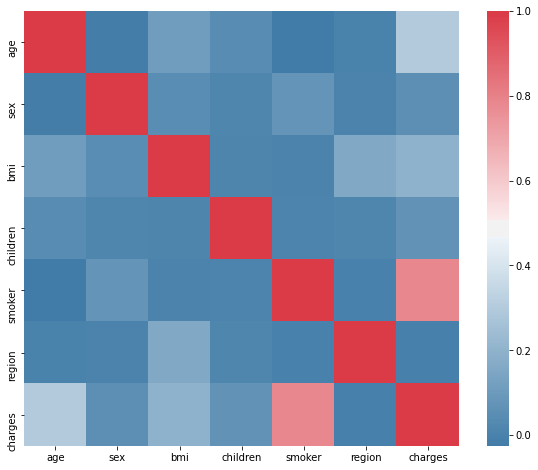

In [ ]:

f, ax = pl.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

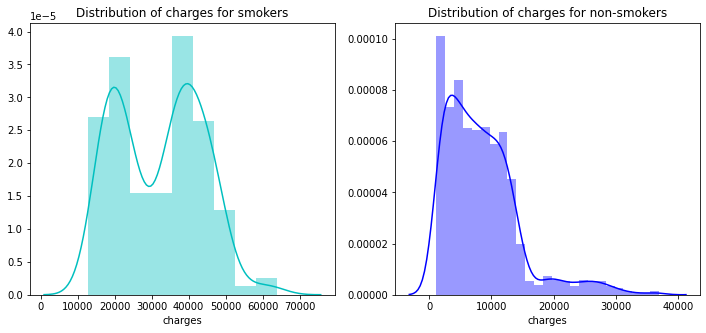

In [ ]:
f= pl.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

흡연 환자들은 치료에 더 많은 돈을 씁니다. 하지만 금연 환자가 더 많다는 느낌이 있습니다. 확인하러 갑니다.

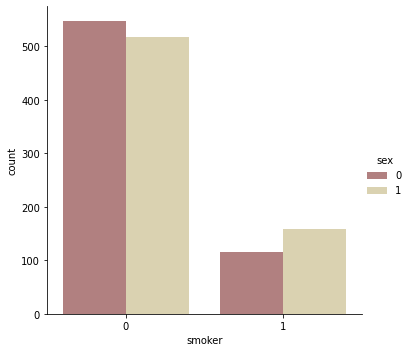

In [ ]:

sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=data)

여성은 "1"과 "남성 - 0"이라는 기호로 코딩되어 있습니다. 따라서 금연자와 진실은 더욱 그렇습니다. 또한 우리는 여성 흡연자보다 남성 흡연자가 더 많다는 것을 알 수 있습니다. 흡연의 영향을 고려할 때 남성의 총 치료비는 여성보다 많을 것으로 추정할 수 있습니다. 아마 나중에 확인해 볼 수 있을 거예요. 좀 더 유용한 시각화도 있습니다.

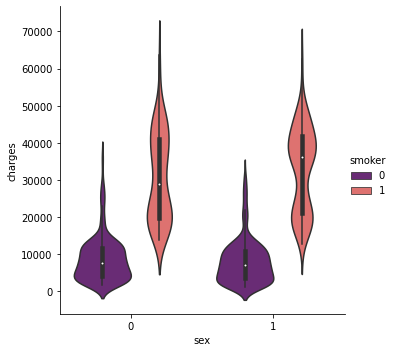

In [ ]:
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=data, palette = 'magma')

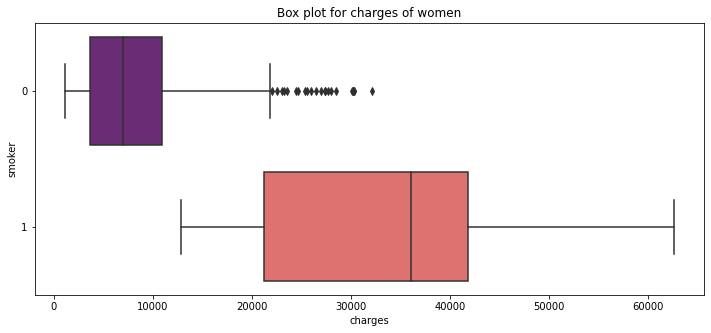

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 1)] , orient="h", palette = 'magma')

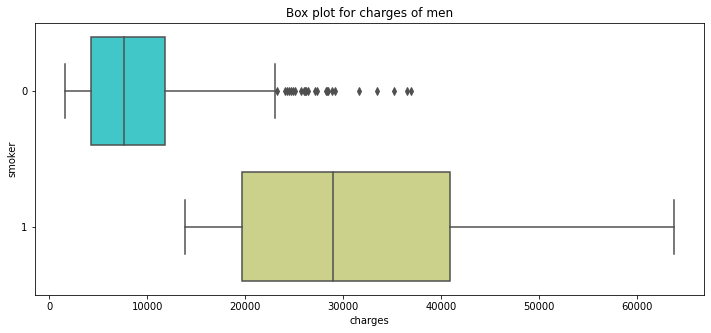

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 0)] , orient="h", palette = 'rainbow')

이제 환자의 연령을 살펴봅시다. 먼저 나이가 치료비에 어떤 영향을 미치는지, 그리고 우리의 데이터 집합에서 어떤 연령의 환자에 대해서도 살펴봅시다.

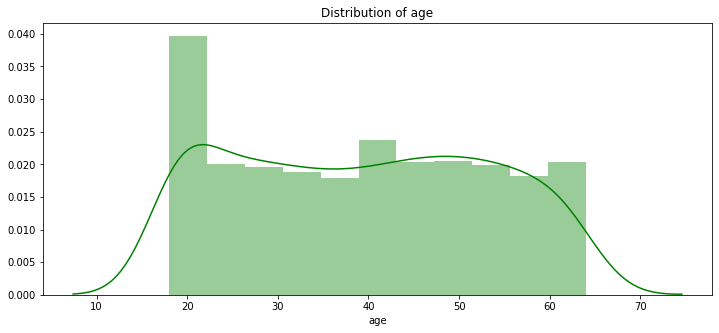

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

데이터 세트에는 20세 미만의 환자가 있습니다. 저는 18살입니다. 저희 세트에서 환자의 최소 연령이고, 최대 연령은 64세입니다. 제 개인적인 관심사는 18년 된 환자 중에 흡연자가 있는지의 여부입니다.

Text(0.5, 1.0, 'The number of smokers and non-smokers (18 years old)')

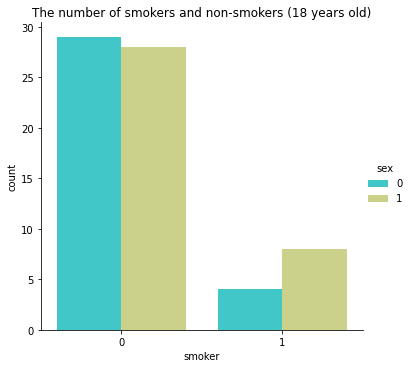

In [ ]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="rainbow", data=data[(data.age == 18)])
pl.title("The number of smokers and non-smokers (18 years old)")

앗. 결과가 달라지길 바랐어요. 18세 - 아주 어린 나이입니다. 흡연이 이 나이에 치료비에 영향을 미칠까요?


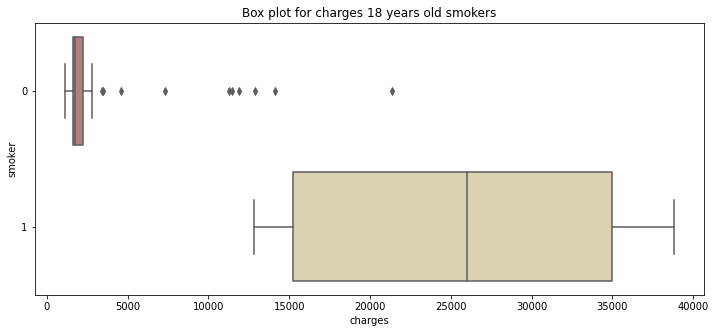

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges 18 years old smokers")
sns.boxplot(y="smoker", x="charges", data = data[(data.age == 18)] , orient="h", palette = 'pink')

![![image.png](attachment:image.png)](https://media.giphy.com/media/bgGainulgkZhK/giphy.gif)

앗. 우리가 알 수 있듯이, 심지어 18세의 흡연자들도 비흡연자들보다 치료에 훨씬 더 많은 돈을 씁니다. 비흡연자들 사이에서 우리는 약간의 "꼬리"를 보고 있습니다. 이것은 심각한 질병이나 사고 때문이라고 추측할 수 있습니다.
이제 흡연자와 비흡연자의 나이에 따라 치료비가 어떻게 달라지는지 알아보겠습니다.

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

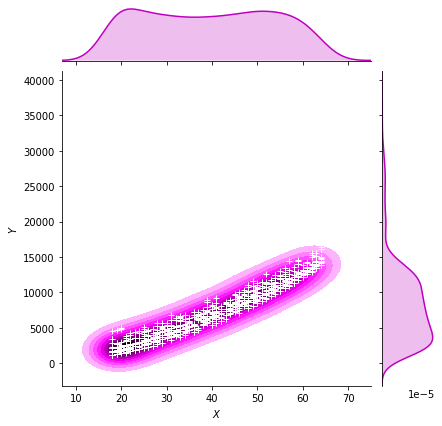

In [ ]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

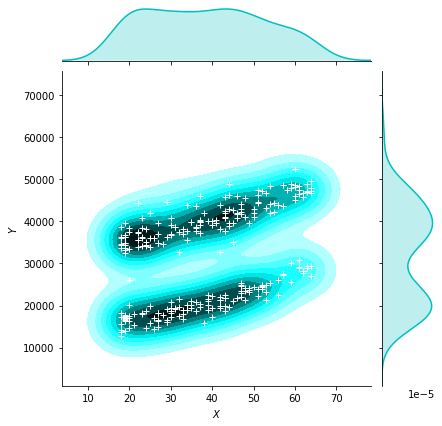

In [ ]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')

In [ ]:
#non - smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 0)].age,y=data[(data.smoker == 0)].charges, size=7, line_color="navy", fill_color="pink", fill_alpha=0.9)

show(p)

In [ ]:
#smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 1)].age,y=data[(data.smoker == 1)].charges, size=7, line_color="navy", fill_color="red", fill_alpha=0.9)
show(p)

Text(0.5, 1.0, 'Smokers and non-smokers')

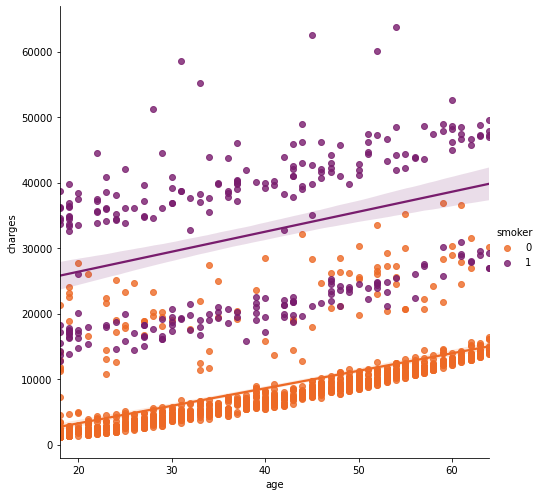

In [ ]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

비흡연자의 경우 나이가 들수록 치료비가 증가합니다. 말이 되네요. 그러니 여러분의 건강을 잘 챙기세요! 흡연자들에게서, 우리는 그런 의존성을 보지 못합니다.
저는 담배뿐만 아니라 데이터 집합의 특색에도 있다고 생각합니다. 흡연이 치료비에 미치는 이러한 강한 영향은 다수의 기록과 기호가 있는 일련의 데이터를 갖는 것을 판단하는 것이 더 논리적일 것입니다.
하지만 우리는 우리가 가진 것을 가지고 일합니다!
이제 MBI에 주목해 보겠습니다. 이 수치는 놀랍지만 환자의 치료비에 영향을 미칩니다. 아니면 괜히 다이어트 하는 건가요?


![![image.png](attachment:image.png)](https://img-s3.onedio.com/id-573af11b92f0c0f951a8561a/rev-0/raw/s-606439d8c0c1e9e794286a8431f3a54c57f31033.gif)

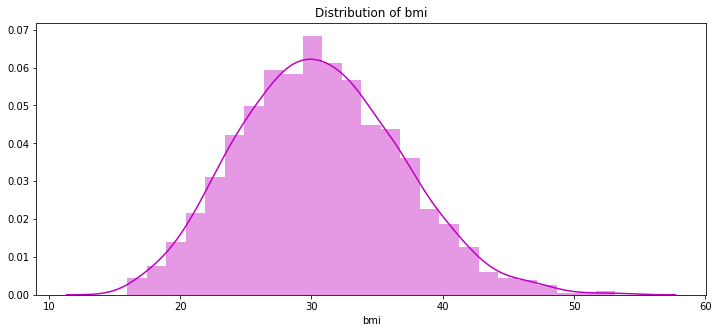

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'm')

이 분포에는 감동적으로 아름다운 게 있죠, 그쵸?
환자의 평균 BMI는 30입니다. 이 지표에 대한 질문을 가지고 Google에 가야 할 것 같아요.


![![image.png](attachment:image.png)](http://1j4g1pasf991x0osxuqz6d10.wpengine.netdna-cdn.com/wp-content/uploads/2017/03/BMI-CHART-1024x791.png)

30과 같은 값이면 비만이 시작됩니다. BMI도 계산해서 부탄츄를 안심하고 먹을 수 있게 되었습니다. 먼저 BMI가 30보다 크고 30보다 적은 환자의 비용 분포를 살펴보겠습니다.

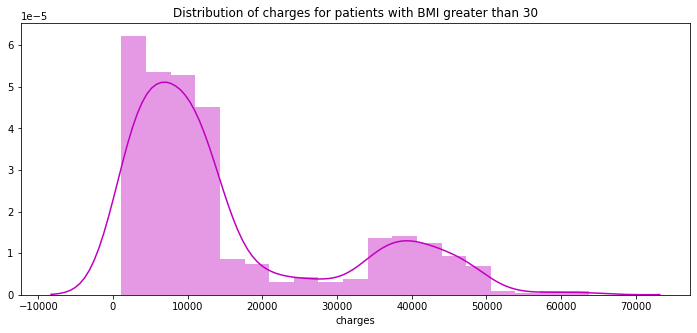

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color = 'm')

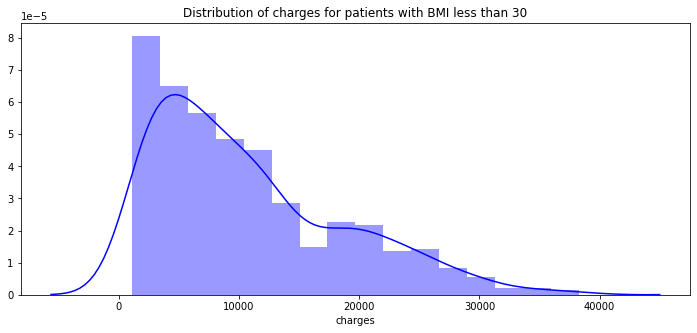

In [ ]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'b')

BMI가 30을 넘는 환자들은 치료에 더 많은 돈을 씁니다!

Text(0.5, 1.0, 'Distribution of bmi and charges')

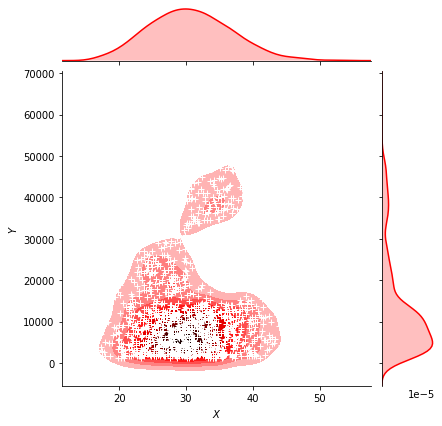

In [ ]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of bmi and charges')


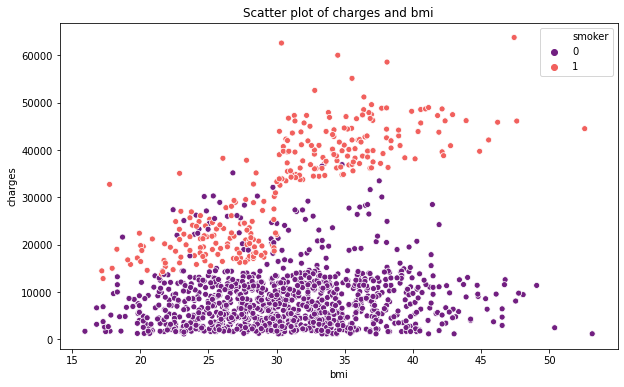

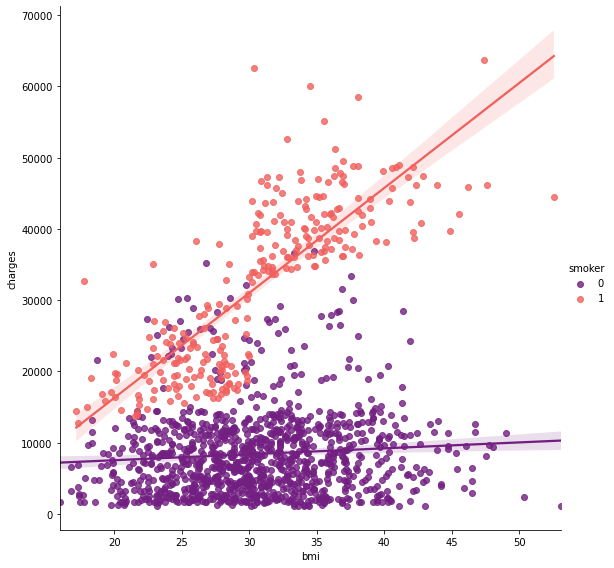

In [ ]:
pl.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

어린이들에게 집중해봅시다. 먼저, 환자들이 얼마나 많은 자녀를 가졌는지 보겠습니다.

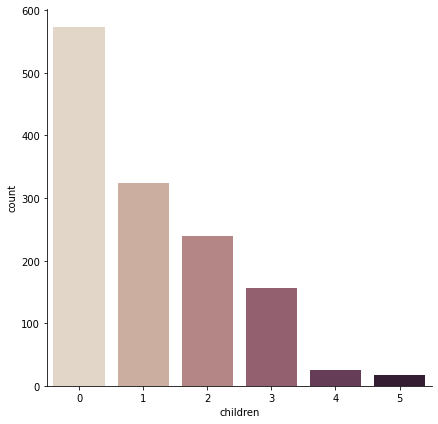

In [ ]:
sns.catplot(x="children", kind="count", palette="ch:.25", data=data, size = 6)

대부분의 환자는 아이가 없습니다. 완벽한 것은 어떤 부모들이 다섯 자녀를 갖고 있다는 것 입니다! 아이들은 행복입니다:)
아이가 있는 부모들이 담배를 피우는 건 아닌지 궁금해지네요.

Text(0.5, 1.0, 'Smokers and non-smokers who have childrens')

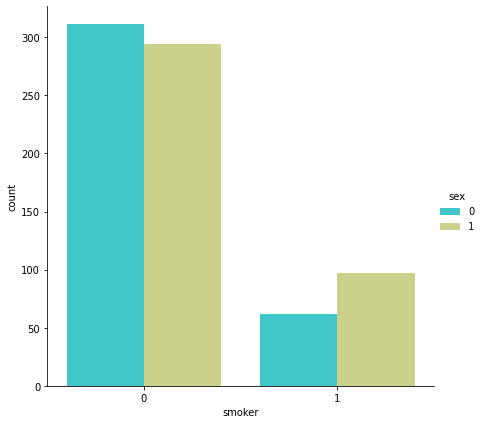

In [ ]:
sns.catplot(x="smoker", kind="count", palette="rainbow",hue = "sex",
            data=data[(data.children > 0)], size = 6)
ax.set_title('Smokers and non-smokers who have childrens')

앗.

![![image.png](attachment:image.png)](https://www.az-jenata.bg/media/az-jenata/files/galleries/640x480/4c0373972cdd156a2e2c008dc5c0a93a.jpg)

그치만 흡연을 하지 않는 부모들이 더 많아서 기쁘네요!

<h1>회귀, 앙상블을 이용한 모델 학습</h1>

지금까지 데이터를 EDA로 분석해보았으니 이제 모델 학습을 해보도록 하겠습니다.

치료 비용을 예측하기 위해서 회귀 알고리즘을 이용할 것입니다. 회귀란 데이터를 독립변수 X와 종속변수 Y 사이의 수학적 관계를 모델링하고 예측하는 방법입니다.

 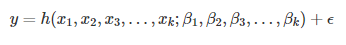

독립변수 X를 집의 속성(방의 개수, 넓이, 세금 등), 종속변수 Y를 집의 가격으로 두면 집의 속성과 집의 가격 사이의 수학적 관계를 찾아 모델링하고 예측을 하는 것을 회귀라고 할 수 있습니다.

이 중에서도 선형 회귀는 X와 Y간의 수학적 관계를 선형 그래프로 나타내어 예측하는 방법입니다.

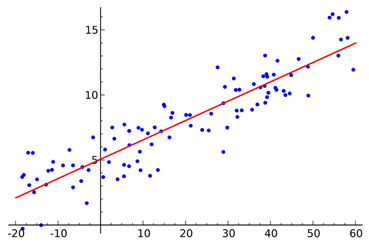
 
X와 Y의 선형적 패턴을 최소제곱법을 이용해 찾아 Y의 값으로 무엇이 나올지를 예측합니다

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
x = data.drop(['charges'], axis = 1)
y = data.charges

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

0.7962732059725786


PolynomialFeatures()는 다항 회귀를 위해 사용하는 전처리 함수인데, 여기서 다항 회귀란 비선형 데이터를 학습할 때 사용하는 회귀로 각 특성의 거듭제곱을 새 특성으로 추가하여 선형 모델로 그려내는 것이라고 할 수 있습니다.


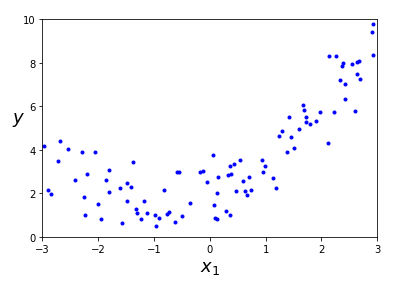

 
예시를 들자면, 이러한 비선형 데이터에서
 

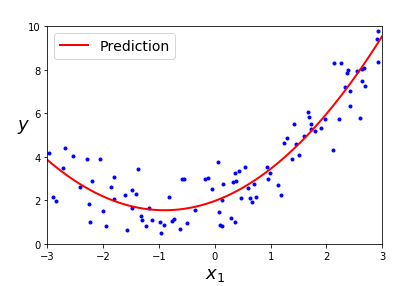

 
이러한 선형 모델을 만들기 위해 PolynomialFeatures()를 이용하여 특성간의 관계를 찾을 수 있도록 도와주는 것입니다.

In [ ]:
X = data.drop(['charges','region'], axis = 1)
Y = data.charges



quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8849197344147228


이번에는 앙상블을 이용해서 학습을 해보도록 하겠습니다. 앙상블이란 모델 하나에 여러가지 데이터 모델을 사용하거나 여러가지 모델을 한 데이터 모델에 적용하여 학습하는 방법으로 앙상블을 학습에 적용함으로써 과적합을 방지하고 성능을 향상시킬 수 있습니다.


앙상블을 이용해 학습하는 방법은 여러가지지만 이번엔 RandomForest를 사용해 학습하였습니다. RandomForest는 하나의 모델에 여러 데이터 모델을 적용하는 Bagging의 대표적인 알고리즘으로 이를 통해 특정 데이터에 편향적이게 학습이 되는 ‘과적합’을 방지할 수 있을겁니다.

 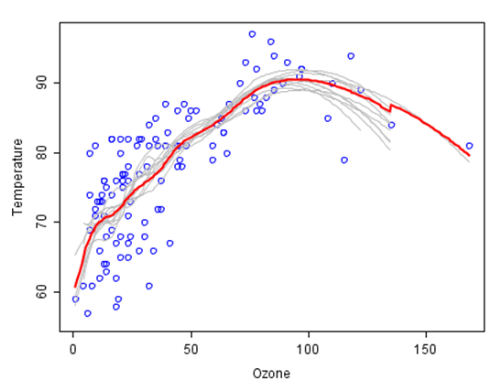

(RandomForest를 이용해 곡선의 기울기를 완만하게 하여 과적합 문제를 해결한 예시)


In [ ]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3729086.094, MSE test data: 19933823.142
R2 train data: 0.974, R2 test data: 0.873


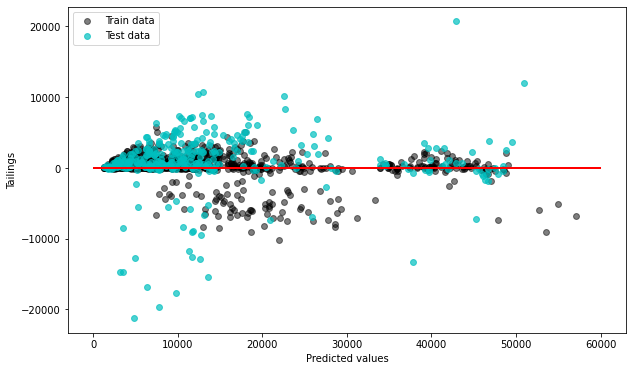

In [ ]:
pl.figure(figsize=(10,6))

pl.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
pl.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
pl.show()

하나의 데이터에 여러가지 모델을 학습시켜 잘못 예측하는 오류를 개선하는 Boosting 알고리즘 중 하나인 GradientBoosting 알고리즘을 사용해 예측하여 보았습니다.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

regr = GradientBoostingRegressor(random_state=0, max_depth=2)
regr.fit(X_train, y_train)
regr.predict(X_test)
accuracy = regr.score(X_test, y_test)
print('GradientBoostingRegressor 정확도: {0:.4f}'.format(accuracy))

GradientBoostingRegressor 정확도: 0.9015


지금까지 EDA와 회귀 알고리즘에 대해 알아보았습니다. 여기까지 봐주셔서 정말 감사합니다!

![감사합니다!](https://lh3.googleusercontent.com/proxy/O8hEve4eYSFiP_TNqX_eC9O4wWVWuTwVee1Bj0HP2QW4Z_dADPeRjb_fGkScL1Tbp-RD1ecqYH6X_bbYVdHf3Cn7u-amoVtZC5yjjJ1-z2GL0Ln7OjGvVcgns1P5XGFFWKPcqYqUB2h-BBAFtr-T9BrNnwJ9AcNpezUfC4yaRc0aQNHDd0Cmbw-4gjJcm-tbqfbwI03YSKSGWoiy3l3mTfPGMQiBU_AxCk6vFzZxkxQ6haBnb19vZ0HLl-bld_dSgjk6B-kze9WnqRnqdAxckI13-DgkQLeQ45z4)
